# Example: projection

[Example Data] https://pan.baidu.com/s/1nwsIcDr <span style="color:gray">(pswd: s5re)</span>

In [1]:
# %load_ext autoreload
# %autoreload 2
%matplotlib notebook

from __future__ import division, print_function
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import sunpy.map
from copy import deepcopy

import sys
sys.path.append('../modules')
from usr_sunpy import read_sdo, plot_map, plot_vmap, image_to_helio

print('Python version: %s' % sys.version.split('(')[0])
print('SunPy version: %s' % sunpy.__version__)

Python version: 3.6.5 |Anaconda, Inc.| 
SunPy version: 0.9.0


## Read data

In [3]:
fnames = ('data/hmi.B_720s.20150827_052400_TAI.field.fits',
          'data/hmi.B_720s.20150827_052400_TAI.inclination.fits',
          'data/hmi.B_720s.20150827_052400_TAI.azimuth.fits',
          'data/hmi.B_720s.20150827_052400_TAI.disambig.fits')

In [4]:
mapb = read_sdo(fnames[0])
mapi = read_sdo(fnames[1])
mapa = read_sdo(fnames[2])
mapd = read_sdo(fnames[3])

hmi.B_720s.20150827_052400_TAI.field.fits	[4096, 4096]
hmi.B_720s.20150827_052400_TAI.inclination.fits	[4096, 4096]
hmi.B_720s.20150827_052400_TAI.azimuth.fits	[4096, 4096]
hmi.B_720s.20150827_052400_TAI.disambig.fits	[4096, 4096]


In [5]:
# Disambiguate
mapa.data[mapd.data > 3] += 180.

mapbx = deepcopy(mapb)
mapby = deepcopy(mapb)
mapbz = deepcopy(mapb)
mapbx.data[:] = mapb.data * np.sin(np.deg2rad(mapi.data)) * np.cos(np.deg2rad(mapa.data + 270.))
mapby.data[:] = mapb.data * np.sin(np.deg2rad(mapi.data)) * np.sin(np.deg2rad(mapa.data + 270.))
mapbz.data[:] = mapb.data * np.cos(np.deg2rad(mapi.data))

# Rotate(CCW)
order = 1
# Suppress metadata warnings if sunpy >= 0.9.0:
mapbx.meta['hgln_obs'] = 0.; mapby.meta['hgln_obs'] = 0.; mapbz.meta['hgln_obs'] = 0.
print('Correcting image axes...')
# Suppress warnings of NaNs:
with np.errstate(invalid='ignore'):
    mapbx = mapbx.rotate(order=order)
    mapby = mapby.rotate(order=order)
    mapbz = mapbz.rotate(order=order)
print('Rotation angle = %f deg (CCW)' % -mapb.meta['crota2'])

Correcting image axes...
Rotation angle = -180.013600 deg (CCW)


## Submap

Submap: (595, 495) = ((500.0, 800.0), (-450.0, -200.0)) arcsec


<IPython.core.display.Javascript object>


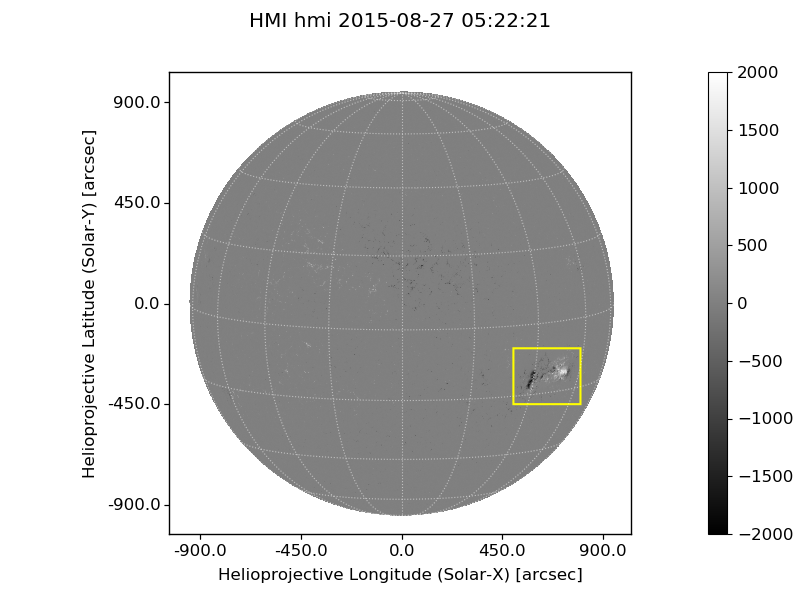

In [6]:
xmin, xmax = (500.,800.)  # arcsec
ymin, ymax = (-450.,-200.)

bl = SkyCoord(xmin*u.arcsec, ymin*u.arcsec, frame=mapbz.coordinate_frame)
tr = SkyCoord(xmax*u.arcsec, ymax*u.arcsec, frame=mapbz.coordinate_frame)
smapbx = mapbx.submap(bl, tr)
smapby = mapby.submap(bl, tr)
smapbz = mapbz.submap(bl, tr)
print('Submap: %s = %s arcsec' % (tuple(map(int, u.Quantity(smapbz.dimensions).value)), ((xmin, xmax), (ymin, ymax))))

fig1 = plt.figure(figsize=(8, 6), dpi=100)
ax1 = fig1.add_subplot(111, projection=mapbz)
plot_map(ax1, mapbz)

# Properties
mapbz.draw_grid(axes=ax1, grid_spacing=20*u.deg, color='w', linestyle=':')
mapbz.draw_rectangle(bl, (xmax-xmin)*u.arcsec, (ymax-ymin)*u.arcsec, axes=ax1, color='yellow', linewidth=1.5)
# ax1.set_title(mapbz.latex_name, y=1.05);
plt.clim(-2000., 2000.)

<IPython.core.display.Javascript object>


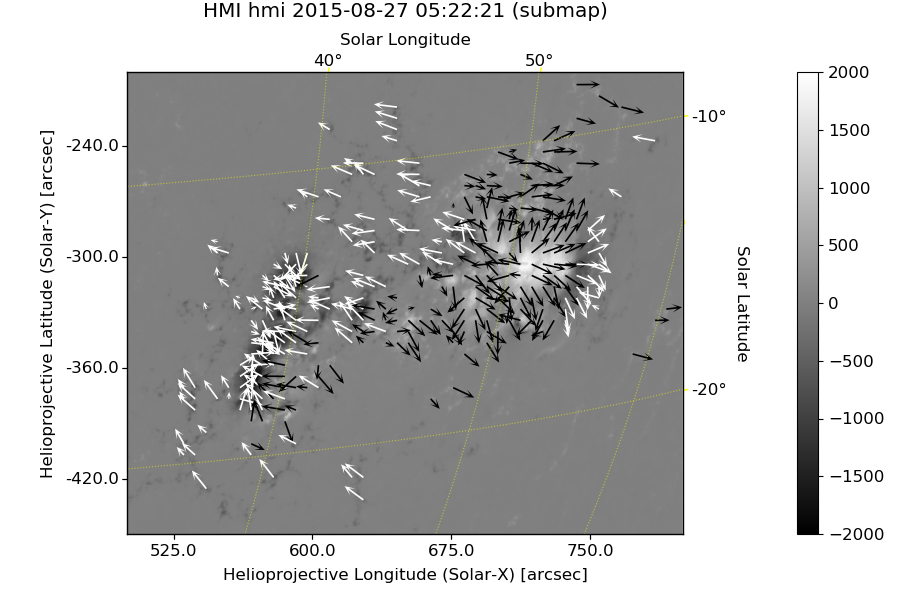

In [7]:
iskip, jskip = (12, 12)

fig2 = plt.figure(figsize=(9, 6), dpi=100)
ax2 = fig2.add_subplot(111, projection=smapbz)
im2 = plot_map(ax2, smapbz)
plot_vmap(ax2, smapbx, smapby, smapbz, iskip=iskip, jskip=jskip, cmin=100., vmax=500., cmap='binary',
          scale_units='xy', scale=1/0.05, minlength=0.02)

# Properties
smapbz.draw_grid(axes=ax2, grid_spacing=10*u.deg, color='yellow', linestyle=':')
ax2.set_title(mapbz.latex_name+' (submap)', y=1.1);
plt.subplots_adjust(right=0.8)  # Reduce the value to move the colorbar to the right
im2.set_clim(-2000., 2000.)

## Projection

In [8]:
hx, hy = image_to_helio(smapbz)
smapbx_h, smapby_h, smapbz_h = image_to_helio(smapbx, smapby, smapbz)

print('(xmin, xmax) = (%9.3f, %9.3f) arcsec\n(ymin, ymax) = (%9.3f, %9.3f) arcsec' %
      (hx.min(), hx.max(), hy.min(), hy.min()))

(xmin, xmax) = ( -252.233,   252.233) arcsec
(ymin, ymax) = ( -156.618,  -156.618) arcsec


<IPython.core.display.Javascript object>


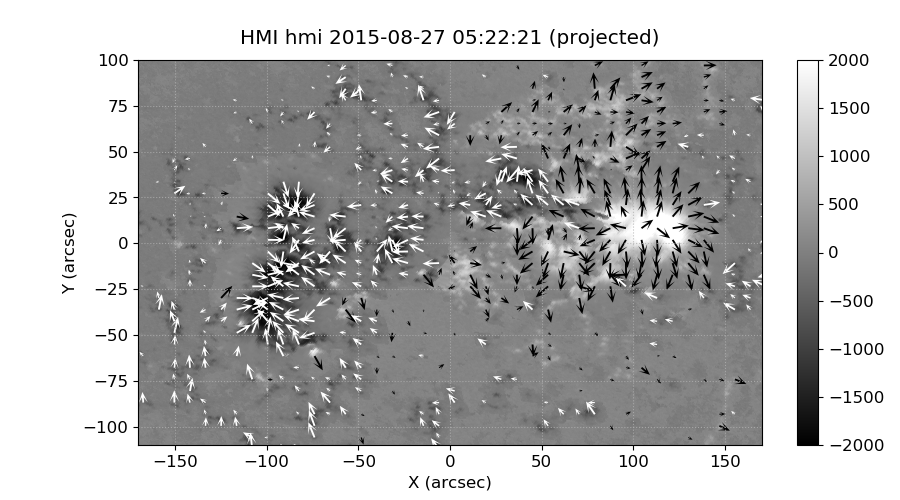

In [9]:
iskip, jskip = (10, 10)

fig3 = plt.figure(figsize=(9, 5), dpi=100)
ax3 = fig3.add_subplot(111)
im3 = plot_map(ax3, smapbz_h, coords=(hx, hy))
plot_vmap(ax3, smapbx_h, smapby_h, smapbz_h, coords=(hx, hy),
          iskip=iskip, jskip=jskip, cmin=100., vmax=300., cmap='binary',
          scale_units='xy', scale=1/0.03, minlength=0.05)

# Properties
ax3.grid(True, ls=':', alpha=0.8)
ax3.set_title(mapbz.latex_name+' (projected)', y=1.02);
plt.subplots_adjust(right=0.9)  # Reduce the value to move the colorbar to the right
ax3.set_xlim((-170,170))
ax3.set_ylim((-110,100))
im3.set_clim((-2000,2000))